In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='attention'

In [6]:
gnn.config.set_gpu(False)

In [7]:
from torch_scatter import scatter_add, scatter_softmax
from torch_geometric.data import Batch


In [8]:
from utils.torchUtils.gnn import sample_pair
from utils.torchUtils import BaseTransform

In [9]:
import utils.torchUtils as gnn 

# transform = gnn.Transform(gnn.SampleCenter(n_pairs=6), builder)
transform = None
template = gnn.Dataset('../data/template',make_template=True, transform=transform)

def load_training(fn='../data/MX_1000_MY_450-training', template=None):
    transform = template.transform
    dataset = gnn.Dataset(fn,transform=transform)[:9000]
    training, validation = gnn.train_test_split(dataset, 0.2)
    # training, validation = dataset[1800:], dataset[:1800]

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return trainloader, validloader

def load_testing(fn='../data/MX_1000_MY_450-testing', template=None):
    transform = template.transform
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    # sample = [ data for data in sample if data.edge_y.sum() > 0 ]
    batch_size = 100
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)
trainloader, validloader  = load_training(template=template)

In [10]:
data = next( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:>)

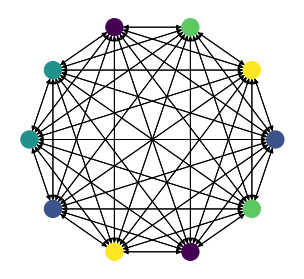

In [11]:
gnn.draw_data(data)

In [12]:
class GATNet(torch.nn.Module):
    def __init__(self, n_in_nodes=None, n_in_edges=None, heads=2):
        super().__init__()
        self.n_in_nodes=n_in_nodes
        self.n_in_edges=n_in_edges if n_in_edges else 0
        self.heads = [
            torch.nn.Sequential(
                torch.nn.Linear(2*n_in_nodes + n_in_edges, 1),
                torch.nn.ReLU()
            )
            for head in range(heads)
        ]

    def forward(self, x, edge_index, edge_attr=None):
        x = [ self.attention(head, x, edge_index, edge_attr) for head in self.heads ]
        x = torch.cat(x, dim=-1)
        return x

    def attention(self, head, x, edge_index, edge_attr=None):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        a = [x_i, x_j] if edge_attr is None else [x_i, x_j, edge_attr]
        a = head(torch.cat(a,dim=-1))
        a = scatter_softmax(a, row, dim=0)
        x = scatter_add(a*x_j, row, dim=0)
        return x



In [13]:
from utils.torchUtils.classifier.LightningModel import LightningModel

from utils.torchUtils import losses

cross_entropy = torch.nn.CrossEntropyLoss()

class AttentionClassifier(LightningModel):
    def __init__(self, loss='std_loss', **kwargs):
        super().__init__(**kwargs)
        self.save_hyperparameters('loss')

    def predict(self, data : Data):
        with torch.no_grad():
            attention_o = self(data)
        return torch.exp(attention_o[:,1])

    def shared_step(self, batch, batch_idx, tag):
        out = self(batch)

        loss = cross_entropy(out, batch.y)

        metrics = dict(loss=loss)

        return metrics

class GoldenAttention(AttentionClassifier):
    name = "golden_attention"
    def __init__(self, nn_embed_1=8, heads_1=8, nn_embed_2=1, heads_2=2, **kwargs):
        super().__init__(**kwargs)

        self.embed_1 = layers.GCNLinear(self.n_in_node, self.n_in_edge, nn_embed_1)
        self.gat_1 = GATNet(nn_embed_1, nn_embed_1, heads_1)
        self.relu_1 = torch.nn.ReLU()

        self.embed_2 = layers.GCNLinear(heads_1*nn_embed_1, nn_embed_1, nn_embed_2)
        self.gat_2 = GATNet(nn_embed_2, nn_embed_2, heads_2)
        self.softmax = torch.nn.Softmax()

    def forward(self, data : Data):
        data = data.to(self.device)
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x, edge_attr = self.embed_1(x, edge_index, edge_attr)
        x = self.gat_1(x, edge_index, edge_attr)
        x = self.relu_1(x)

        x, edge_attr = self.embed_2(x, edge_index, edge_attr)
        x = self.gat_2(x, edge_index, edge_attr)
        x = self.softmax(x)

        return x

In [14]:
model = GoldenAttention(dataset=template)

In [15]:
model.shared_step(data, 1, '')

{'loss': tensor(0.6932, grad_fn=<NllLossBackward>)}

In [16]:
for batch in trainloader: break


In [17]:
model(batch)

tensor([[0.5002, 0.4998],
        [0.5000, 0.5000],
        [0.5001, 0.4999],
        ...,
        [0.5000, 0.5000],
        [0.4999, 0.5001],
        [0.5000, 0.5000]], grad_fn=<SoftmaxBackward>)

In [18]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=5, gpus=1*gnn.config.ngpu)
trainer.fit(model, trainloader, validloader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type      | Params
--------------------------------------
0 | embed_1 | GCNLinear | 96    
1 | gat_1   | GATNet    | 0     
2 | relu_1  | ReLU      | 0     
3 | embed_2 | GCNLinear | 74    
4 | gat_2   | GATNet    | 0     
5 | softmax | Softmax   | 0     
--------------------------------------
170       Trainable params
0         Non-trainable params
170       Total params
0.001     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 90/90 [00:07<00:00, 12.23it/s, loss=0.655, v_num=4]


In [ ]:
trainer.test(model, validloader);

Testing: 100%|██████████| 18/18 [00:55<00:00,  2.95s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hits/test': 0.5294445157051086,
 'loss/test': 1.5541365146636963,
 'maxhits/test': 0.5294445157051086,
 'neg_loss/test': 0.48374584317207336,
 'pos_loss/test': 0.5254967212677002,
 'rank_loss/test': 0.5448939800262451}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 18/18 [00:56<00:00,  3.11s/it]


In [32]:
class predict_data(gnn.BaseTransform):
    def __init__(self, model=model):
        super().__init__()
        self.model = model.to('cpu')
    def __call__(self, data : Data) -> Data:
        pairs = torch.LongTensor([ [i,j] for i in range(data.num_nodes) for j in range(i+1, data.num_nodes)])
        def predict_pair(data, pair):
            data = gnn.sample_pair(data, pair).to(self.model.device)
            return self.model.predict(data)
        edge_o = torch.Tensor([predict_pair(data, pair) for pair in pairs])
        min_o, max_o = edge_o.min(), edge_o.max()
        data.edge_o = (edge_o-min_o)/(max_o+min_o)
        data.rank_o = data.edge_o.argsort(descending=True).argsort()
        return data

In [33]:
gnn.config.set_gpu(0)

In [34]:
def load_testing(fn='../data/MX_1000_MY_450-testing', template=None):
    transform = template.transform + predict_data() + gnn.to_uptri_graph()
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    batch_size = 10
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)

In [35]:
tophit = torch.Tensor([ batch.edge_y[batch.rank_o == 0].float().mean() for batch in testloader ])

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

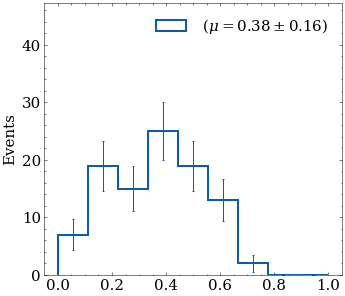

In [36]:
hist_multi([tophit], legend=True, h_label_stat='mean_stdv', bins=np.linspace(0,1,10))

In [37]:
dataiter = iter( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10)

In [38]:
data = next(dataiter)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

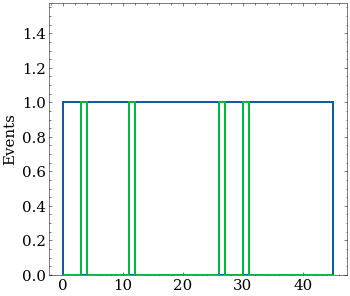

In [39]:
hist_multi([data.rank_o[data.edge_y == 0], data.rank_o[data.edge_y==1]], errors=False)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:>)

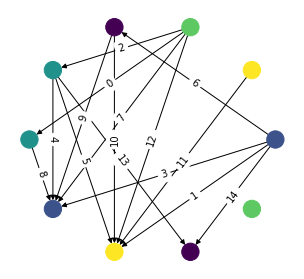

In [40]:
colmap = {True:[0,0,0], False:[1,0,0]}
edge_color = torch.Tensor([ colmap[int(y)] for y in data.edge_mask ])

gnn.draw_data(data, edge_labels=data.rank_o, edge_mask=data.rank_o<15, edge_color=edge_color)